In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.utils import resample
import yfinance as yf

In [54]:
data = yf.download('AAPL', start='2015-01-01', end='2025-01-01')
data = data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [55]:
data['Lag1'] = data['Close'].shift(1)
data = data.dropna()

In [56]:
X = data[['Lag1']]
y = data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [57]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Обучение моделей

In [58]:
#Gradient Boosting
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

/home/trueuser/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(random_state=42)

In [59]:
#XGBoost
xgbr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [60]:
import warnings

warnings.filterwarnings('ignore')

In [61]:
# 3. Применение метода Монте-Карло
n_simulations = 30
gbr_preds = []
xgbr_preds = []

for i in range(n_simulations):
    # Получаем случайные подвыборки (bootstrap sampling)
    X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
    
    # Обучаем модель на случайной подвыборке
    gbr.fit(X_resampled, y_resampled)
    xgbr.fit(X_resampled, y_resampled)
    
    # Делаем предсказания на тестовых данных
    gbr_preds.append(gbr.predict(X_test))
    xgbr_preds.append(xgbr.predict(X_test))

In [62]:
gbr_preds = np.array(gbr_preds)
xgbr_preds = np.array(xgbr_preds)

# Оценка моделей

In [63]:
gbr_mean_preds = np.mean(gbr_preds, axis=0)
xgbr_mean_preds = np.mean(xgbr_preds, axis=0)

In [64]:
n_preds = np.mean(xgbr_preds, axis=0)

In [65]:
gbr_mse = mean_squared_error(y_test, gbr_mean_preds)
xgbr_mse = mean_squared_error(y_test, xgbr_mean_preds)

In [66]:
gbr_r2 = r2_score(y_test, gbr_mean_preds)
xgbr_r2 = r2_score(y_test, xgbr_mean_preds)

In [67]:
print(f"Gradient Boosting MSE: {gbr_mse:.4f}")
print(f"XGBoost MSE: {xgbr_mse:.4f}")
print(f"Gradient Boosting R²: {gbr_r2:.4f}")
print(f"XGBoost R²: {xgbr_r2:.4f}")

Gradient Boosting MSE: 4.6817
XGBoost MSE: 4.9061
Gradient Boosting R²: 0.9989
XGBoost R²: 0.9989


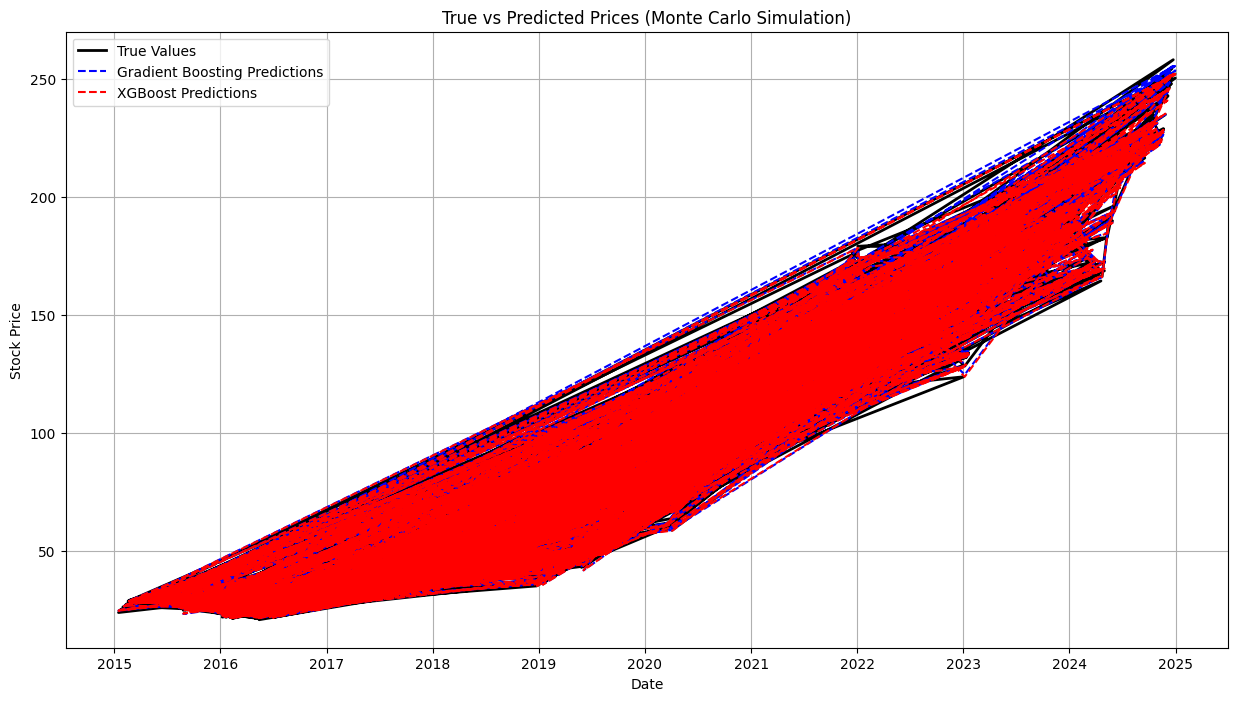

In [74]:
plt.figure(figsize=(15, 8))

# Истинные значения
plt.plot(y_test.index, y_test, label='True Values', color='black', linewidth=2)

# Предсказания моделей
plt.plot(y_test.index, gbr_mean_preds, label='Gradient Boosting Predictions', color='blue', linestyle='--')
plt.plot(y_test.index, xgbr_mean_preds, label='XGBoost Predictions', color='red', linestyle='--')


plt.title('True vs Predicted Prices (Monte Carlo Simulation)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
if gbr_r2 > xgbr_r2:
    print("Gradient Boosting is the better model based on R² and MSE.")
else:
    print("XGBoost is the better model based on R² and MSE.")

Gradient Boosting is the better model based on R² and MSE.
